In [1]:
# General
import pandas as pd 
import numpy as np
from ast import literal_eval
from collections import Counter, OrderedDict
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import pickle
import joblib
from time import time
from wordcloud import WordCloud
import nltk
from nltk.util import ngrams,everygrams
import json

# Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# LDA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation

# NMF
from sklearn import decomposition

# Word2Vec
from gensim.models import Word2Vec
import multiprocessing
import logging
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

# Load Data

The 'parsed_trainfile.csv' can be found in the Processed JSONs folder in th shared drive - https://drive.google.com/drive/folders/1eDEeQldaYod7bWUD1Sr9Q3KaP_MzNK9X?usp=sharing

In [2]:
# Modify this path to point to where the data is saved
reldatapath = '../data/'
filepath = 'parsed_trainfile.csv'
df = pd.read_csv(reldatapath+filepath)
df.ingredients = [literal_eval(x) for x in df.ingredients]
df = df.drop(columns = ['Unnamed: 0'])
df.head()

,ingredients,url,partition,title,id,instructions
0,"[penne, beechers flagship cheese sauce, chedda...",http://www.epicurious.com/recipes/food/views/-...,train,worlds mac cheese,000018c8a5,[{'text': 'Preheat the oven to 350 F. Butter o...
1,"[elbow macaroni, cubed american cheese, sliced...",http://cookeatshare.com/recipes/dilly-macaroni...,train,dilly macaroni salad,000033e39b,[{'text': 'Cook macaroni according to package ...
2,"[tomatoes quartered, kosher salt, red onion cu...",http://www.foodnetwork.com/recipes/gazpacho1.html,train,gazpacho,000035f7ed,[{'text': 'Add the tomatoes to a food processo...
3,"[watermelon gelatin, boiling water, cool whip ...",http://www.food.com/recipe/cool-n-easy-creamy-...,train,cool easy creamy watermelon pie,00004320bb,"[{'text': 'Dissolve Jello in boiling water.'},..."
4,"[shredded coconut, lean ground beef, -2 minced...",http://www.food.com/recipe/easy-tropical-beef-...,train,easy tropical beef skillet,0000631d90,"[{'text': 'In a large skillet, toast the cocon..."


## Further Cleaning

In [3]:
# Clean ingredients further with manually observed tokens
stopwords = ['chopped','diced','sliced','minced','10','oz','roughly','cut','half',10,"'10'", 'grams', 'slices','peeled','divided','g','t','','.','x','cubed','trimmed','sm','lg','possibly',
'ml','slice','grated']
def clean_ing(ingr_list):
    new_words = []
    for word in ingr_list:
        new_ing = []
        split = word.split()
        for subword in split:
            if subword.lower() not in stopwords:
                new_ing.append(subword.lower())
        new_ing = ' '.join(new_ing)
        new_words.append(new_ing)
    return new_words

df.ingredients = df.ingredients.apply(clean_ing)

# Setup vectorizer inputs
string_ingr = [] # input strings (documents) for vectorizer
vocab = set() # vocabulary for vectorizer
for ingr_list in df.ingredients:
    string_ingr.append(' '.join(ingr_list))
    vocab.update(ingr_list)   
vocab = {term: i for i,term in enumerate(vocab)}

# Load Models

Pretrained model can be found in the 'models' folder in the shared drive - https://drive.google.com/drive/folders/1I0fis_QXvMf3_R9H2T1LS8uqK2ywPVQn?usp=sharing

In [35]:
# Modify this path to point to where the models are saved
relmodelpath = '../models/'

## Vectorizer

In [5]:
# load fitted vectorizer (~34 sec)
with open(relmodelpath+'vectorizer.pkl','rb') as f:
    vectorizer = pickle.load(f)
vect_ingr = vectorizer.transform(string_ingr)
vect_features = vectorizer.get_feature_names_out()
titles = df.title

# Uncomment below to refit vectorizer
# # Create and fit vectorizer
# vectorizer = CountVectorizer(ngram_range=(1, 3), min_df=10, max_df=1.0, stop_words="english", max_features=2000, vocabulary=vocab)  
# vect_ingr = vectorizer.fit_transform(string_ingr)

# # Setup output vectors for later
# titles = df.title
# vect_features = vectorizer.get_feature_names_out()

# # Save fitted vectorizer
# with open('nmf_models/vectorizer.pkl','wb') as f:
#     pickle.dump(vectorizer,f)

## LDA Models

In [6]:
# Setup LDA
ns = [5,10,20,30,40]
# If already trained, load models
ldas = []
for n in ns:
    filename = relmodelpath+'lda_models/lda_model_n{}.pkl'.format(n)
    with open(filename,'rb') as f:
        ldas.append(pickle.load(f))

# Else, uncomment to train (~180 min)
# ldas = []
# for n in tqdm(ns):
#     lda = LatentDirichletAllocation(n_components = n, random_state=0,n_jobs=6,verbose=3)
#     lda.fit(vect_ingr) # fit to the vectorized ingredients list
#     ldas.append(lda)

# # Save Models
# for i,lda in enumerate(ldas):
#     filename = 'lda_models/lda_model_n{}.pkl'.format(ns[i])
#     with open(filename,'wb') as f:
#             pickle.dump(lda, f)


## NMF Models

In [7]:
# Setup NMF
ns = [5,10,20,30,40]
# If already trained, load models (~45 sec)
nmfs = []
Ws = []
Hs = []
for n in ns:
    filename = relmodelpath+'nmf_models/nmf_model_n{}.pkl'.format(n)
    with open(filename,'rb') as f:
        nmf = pickle.load(f)
        nmfs.append(nmf)
        Ws.append(nmf.transform(vect_ingr))
        Hs.append(nmf.components_)

# Else, uncomment to train (~33 min)
# nmfs = []
# Ws = []
# Hs = []
# for n in tqdm([5,10,20,30,40]):
#     nmf = decomposition.NMF(n_components=n, random_state=0, init="nndsvd")
#     nmf.fit(vect_ingr) # fit to the vectorized ingredients list
#     nmfs.append(nmf)
#     Ws.append(nmf.transform(vect_ingr))
#     Hs.append(nmf.components_)

# # Save Models
# for i,nmf in enumerate(nmfs):
#     filename = 'models/nmf_models/nmf_model_n{}.pkl'.format(ns[i])
#     with open(filename,'wb') as f:
#             pickle.dump(nmf, f)

## W2V model

In [8]:
# load w2v model if already trained
with open(relmodelpath+'word2vec_model.pkl','rb') as f:
        w2v_model = pickle.load(f)

## uncomment to train new w2v model
# cores = multiprocessing.cpu_count()
# w2v_model = Word2Vec(min_count=20,
#                      window=2,
#                      vector_size=2000,
#                      sample=6e-5, 
#                      alpha=0.03, 
#                      min_alpha=0.0007, 
#                      negative=20,
#                      workers=cores-1)

# word_freq = Counter()
# for word_list in df.ingredients: 
#         word_freq.update(word_list)
# print(word_freq.most_common(5))

# # Train w2v model (takes ~12 min)
# w2v_model.build_vocab_from_freq(word_freq)
# t = time()
# w2v_model.train(df.ingredients, total_examples=df.ingredients.shape[0], epochs=30, report_delay=1)
# print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

# with open('models/lda_models/word2vec_model.pkl','wb') as f:
#         pickle.dump(w2v_model, f)

# Helper Functions

## Display Topics

In [9]:
def display_topics(model, feature_names, no_top_words, idx=None):
    """
    if index is specified, the function will print the topic words for that index
    and return the terms

    if no index is specified it will print all of the words for each topic with no return
    """

    if idx != None:
       topic = model.components_[idx]
       term_list = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
       print("topic %d:" % (idx), term_list)
       return term_list
    else:    
        for topic_idx, topic in enumerate(model.components_):
            term_list = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
            print("topic %d:" % (topic_idx), term_list)

num_top_words = 8
display_topics(ldas[2], vect_features, num_top_words)

topic 0: ['flour', 'water', 'salt', 'sugar', 'butter', 'milk', 'oil', 'purpose flour']
topic 1: ['chicken', 'boneless', 'skinless', 'breasts', 'chicken breasts', 'skinless chicken', 'boneless skinless chicken', 'breast']
topic 2: ['cheese', 'pepper', 'shredded', 'onion', 'salt', 'cheddar', 'cheddar cheese', 'butter']
topic 3: ['pepper', 'red', 'garlic', 'fresh', 'salt', 'oil', 'cloves', 'ground']
topic 4: ['ground', 'cinnamon', 'sugar', 'brown', 'brown sugar', 'ground cinnamon', 'nutmeg', 'butter']
topic 5: ['cream', 'dash', 'sour', 'pepper', 'sour cream', 'salt', 'sauce', 'butter']
topic 6: ['cheese', 'parmesan', 'olive', 'fresh', 'olive oil', 'oil', 'parmesan cheese', 'basil']
topic 7: ['inch', 'potatoes', 'pieces', 'inch pieces', 'carrots', 'cubes', 'sweet', 'beef']
topic 8: ['oil', 'olive', 'olive oil', 'vinegar', 'red', 'fresh', 'lemon', 'salt']
topic 9: ['sauce', 'powder', 'salt', 'pepper', 'garlic', 'onion', 'mustard', 'pork']
topic 10: ['sugar', 'butter', 'unsalted', 'unsalted 

## Summarize Topics

In [10]:
def summarize_topic(top_recipes_per_topic,top_scores_per_topic,n_topics, num_top_recipes=20):
    # summarize topics from most common tokens in recipe titles | also return top recipe titles
    # num_top_recipes = 20 # number of recipes to be included in token counting
    num_top_words_in_topic = 8 # number of tokens to display from each topic
    num_summary_tokens = 6 # number of tokens to summarize recipe titles
    num_summary_recipes = 5 # number of recipes to display
    num_top_words = 8 # number of words to display
    
    most_commons = []
    for topic_index in range(0, n_topics):
        top_indices = top_recipes_per_topic[0:num_top_recipes, topic_index]
        top_titles = titles[top_indices]
        top_title_scores = top_scores_per_topic[0:num_top_recipes, topic_index]
        top_title_scores = [round(score,3) for score in top_title_scores]

        tokens = Counter()
        for title in top_titles.values:
            title_toks = title.split()
            ngrams = list(everygrams(title_toks, max_len = 2))
            n_gram_tokens = []
            for gram in ngrams:
                combined = []
                for i in range(len(gram)):
                    combined.append(gram[i])
                combined = ' '.join(combined)
                n_gram_tokens.append(combined)
            tokens.update(n_gram_tokens)

        most_common = tokens.most_common(num_summary_tokens)
        most_commons.append(most_common)
        mc_sum = sum([x[1] for x in most_common])
        tok_return = [(x[0], str(round(100*x[1]/mc_sum,1))+'%') for x in most_common]
        
        display_topics(lda, vect_features, num_top_words, topic_index)
        print("Most common tokens in recipes for topic", topic_index, "are:\n", tok_return)

        title_output = list(zip(top_titles[:num_summary_recipes].values, top_title_scores))
        print("Highest topic", topic_index, "weighted recipes are:\n", title_output)
        print('\n') 
    return most_commons

## Make Word Cloud

In [11]:
def make_wordcloud(most_common):
    toks = {x[0]:x[1] for x in most_common}
    wc = WordCloud(prefer_horizontal=1, background_color='white')
    wc.generate_from_frequencies(toks)
    # ax.imshow(wc, interpolation='bilinear')
    # ax.axis('off')
    return wc

# LDA

In [12]:
# transform vectorized ingredients to LDA space (~3 min)
lda_outputs = []
top_recipes = []
top_scores = []
for lda in ldas:
    lda_output = lda.transform(vect_ingr)
    top_recipes_per_topic = np.argsort(lda_output, axis = 0)[::-1] # sort recipes for each topic
    top_scores_per_topic = np.sort(lda_output, axis = 0)[::-1] # sort recipes for each topic

    lda_outputs.append(lda_output)
    top_recipes.append(top_recipes_per_topic)
    top_scores.append(top_scores_per_topic)

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   3 out of  12 | elapsed:   22.8s remaining:  1.1min
[Parallel(n_jobs=12)]: Done  10 out of  12 | elapsed:   23.2s remaining:    4.6s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:   23.3s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:   36.1s remaining:   36.1s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:   36.5s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   3 out of  12 | elapsed:   25.9s remaining:  1.3min
[Parallel(n_jobs=12)]: Done  10 out of  12 | elapsed:   26.2s remaining:    5.2s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:   26.5s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   3 out of  12 | elapsed:   24.4s remaining:  1.2m

### Log-Like and Perplexity

In [13]:
# Compute log-likelihood and perplexity (~11 min)
log_like = []
perplex = []
for lda in ldas:
    log_like.append(lda.score(vect_ingr))
    perplex.append(lda.perplexity(vect_ingr))

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   3 out of  12 | elapsed:   22.5s remaining:  1.1min
[Parallel(n_jobs=12)]: Done  10 out of  12 | elapsed:   23.2s remaining:    4.6s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:   23.2s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   3 out of  12 | elapsed:   20.7s remaining:  1.0min
[Parallel(n_jobs=12)]: Done  10 out of  12 | elapsed:   21.6s remaining:    4.2s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:   21.8s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:   34.3s remaining:   34.3s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:   35.5s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:   33.4s remaining:   33.4s


INFO - 12:51:14: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - 12:51:14: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - 12:51:14: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - 12:51:14: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - 12:51:14: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appr

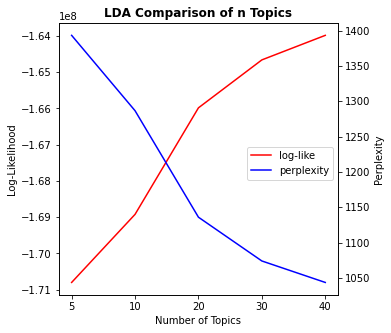

In [14]:
# create log-like and perplexity graph
xlab = [str(n) for n in ns]

fig, ax1 = plt.subplots(figsize=(5,5))
ax1.plot(xlab,log_like,c='red',label='log-like')
ax1.set_xlabel('Number of Topics')
ax1.set_ylabel('Log-Likelihood')
ax1.set_title('LDA Comparison of n Topics', weight='bold')

ax2 = ax1.twinx()
ax2.plot(xlab,perplex,c='blue',label='perplexity')
ax2.set_ylabel('Perplexity')

fig.legend(bbox_to_anchor=(.9,.55))


## LDA Topic Coherence Functions

In [15]:
# check similarity of topics to themselves and take average
def lda_topic_coherence(model,n_topics,n_top_words=50):
    total_avg = []
    for idx in range(n_topics):
        topic = model.components_[idx]
        term_list = [vect_features[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        scores = []
        for term1 in term_list:
            for term2 in term_list:
                if term1 != term2:
                    try:
                        scores.append(w2v_model.wv.similarity(w1=term1, w2=term2))
                    except:
                        pass
        total_avg.append(np.mean(scores))
    return np.mean(total_avg)

lda_avg_coherence = []
for i,lda in enumerate(ldas):
    lda_avg_coherence.append(lda_topic_coherence(lda,ns[i]))

In [16]:
def plot_coherence(avg_coherence, ax, model_type):
    xlabels = [str(x) for x in ns]
    ax.plot(xlabels,avg_coherence, c='blue',label = 'Coherence')
    ax.scatter(xlabels,avg_coherence)
    ax.set_xlabel('Number of Topics')
    ax.set_ylabel('Average Topic Coherence')
    ax.set_title('{} Topic Coherence vs Number of Topics'.format(model_type), weight='bold')
    ax.axhline(y=np.mean(avg_coherence), c='red', label='Mean')
    # plt.legend()|

## LDA Word Cloud

topic 0: ['flour', 'water', 'salt', 'milk', 'sugar', 'butter', 'purpose flour', 'yeast']
Most common tokens in recipes for topic 0 are:
 [('bread', '48.4%'), ('wheat', '12.9%'), ('butter', '9.7%'), ('bread machine', '9.7%'), ('machine', '9.7%'), ('rye', '9.7%')]
Highest topic 0 weighted recipes are:
 [('bagels', 0.982), ('bagels', 0.982), ('butter rich roll bread', 0.981), ('rustic bread bread machine', 0.98), ('% wheat bread iii', 0.98)]


topic 1: ['cubes', 'chicken', 'inch cubes', 'bouillon', 'inch', 'water', 'curry', 'curry powder']
Most common tokens in recipes for topic 1 are:
 [('chicken', '42.4%'), ('rice', '21.2%'), ('soup', '15.2%'), ('chicken rice', '9.1%'), ('wings', '6.1%'), ('rice soup', '6.1%')]
Highest topic 1 weighted recipes are:
 [('hot wings', 0.98), ('east chicken stir fry', 0.971), ('chicken curry', 0.969), ('chicken rice soup', 0.967), ('regular chicken soup', 0.966)]


topic 2: ['cheese', 'parmesan', 'parmesan cheese', 'shredded', 'italian', 'mozzarella', 'mozza

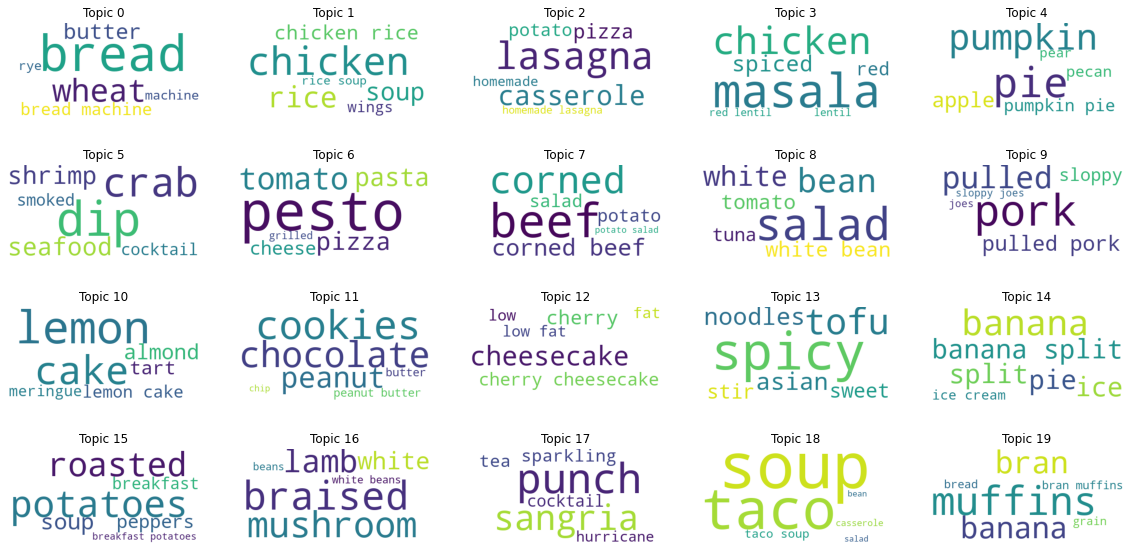

In [17]:
most_commons = summarize_topic(top_recipes[2],top_scores[2],20,20)

rows = int(len(most_commons)/5)
cols = int(len(most_commons)/rows)
figy = rows*5/2
fig = plt.figure(figsize=(20,figy))
for i, most_common in enumerate(most_commons):
    ax = fig.add_subplot(rows,cols,i+1)
    wc = make_wordcloud(most_common)
    ax.imshow(wc)
    ax.axis('off')
    ax.set_title('Topic '+str(i))
plt.savefig('word_cloud')   

# NMF

### Reconstruction Error

In [18]:
# Get reconstruction error for each NMF model
errs = []
for nmf in nmfs:
    errs.append(nmf.reconstruction_err_)

INFO - 12:51:22: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - 12:51:22: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 1.0, 'NMF Comparison of n Topics')

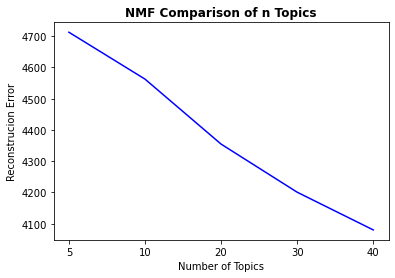

In [19]:
# Plot reconstrucion error
xlabels = [str(x) for x in ns]
plt.plot(xlabels,errs, c='blue')
plt.xlabel('Number of Topics')
plt.ylabel('Reconstrucion Error')
plt.title('NMF Comparison of n Topics', weight='bold')

### NMF Topic Coherence Functions

In [20]:
def nmf_topic_coherence(model,n_topics,n_top_words=50):
    total_avg = []
    for idx in range(n_topics):
        topic = H[idx,:]
        term_list = [vect_features[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        scores = []
        for term1 in term_list:
            for term2 in term_list:
                if term1 != term2:
                    try:
                        scores.append(w2v_model.wv.similarity(w1=term1, w2=term2))
                    except:
                        scores.append(0)
                        pass
        total_avg.append(np.mean(scores))
    return np.mean(total_avg)

nmf_avg_coherence = []
for i,H in enumerate(Hs):
    nmf_avg_coherence.append(nmf_topic_coherence(H,ns[i]))

### NMF Word Cloud

In [21]:
# Display Topic Vectors for NMF
top = 8
topic_index_max = 10
H = Hs[1]
for topic_index in range(0, topic_index_max):
    top_indices = np.argsort(H[topic_index, :])[::-1]
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append(vect_features[term_index])
    print("topic ", topic_index, top_terms)

topic  0 ['oil', 'olive', 'olive oil', 'garlic', 'virgin olive oil', 'extra virgin olive', 'salt', 'cloves']
topic  1 ['sugar', 'butter', 'vanilla', 'cream', 'extract', 'brown', 'brown sugar', 'chocolate']
topic  2 ['cheese', 'cream', 'shredded', 'cheddar', 'cheddar cheese', 'parmesan', 'parmesan cheese', 'cream cheese']
topic  3 ['fresh', 'leaves', 'parsley', 'fresh parsley', 'cilantro', 'inch', 'fresh cilantro', 'basil']
topic  4 ['pepper', 'salt', 'red', 'onion', 'garlic', 'salt pepper', 'black', 'green']
topic  5 ['sauce', 'oil', 'soy', 'garlic', 'soy sauce', 'water', 'sesame', 'green']
topic  6 ['ground', 'black', 'black pepper', 'ground black pepper', 'freshly', 'freshly ground', 'freshly ground black', 'salt freshly ground']
topic  7 ['flour', 'baking', 'salt', 'powder', 'purpose flour', 'baking powder', 'soda', 'baking soda']
topic  8 ['chicken', 'broth', 'chicken broth', 'boneless', 'skinless', 'breasts', 'chicken breasts', 'skinless chicken']
topic  9 ['juice', 'lemon', 'lemo

In [22]:
nmf_top_recipes = []
nmf_top_scores = []
for lda in ldas:
    top_recipes_per_topic = np.argsort(Ws[2], axis = 0)[::-1] # sort recipes for each topic
    top_scores_per_topic = np.sort(Ws[2], axis = 0)[::-1] # sort recipes for each topic

    nmf_top_recipes.append(top_recipes_per_topic)
    nmf_top_scores.append(top_scores_per_topic)

topic 0: ['flour', 'water', 'salt', 'milk', 'sugar', 'butter', 'purpose flour', 'yeast']
Most common tokens in recipes for topic 0 are:
 [('sauce', '19.4%'), ('roasted', '19.4%'), ('grilled', '16.7%'), ('salad', '16.7%'), ('tomato', '13.9%'), ('caramelized', '13.9%')]
Highest topic 0 weighted recipes are:
 [('grilled pizza crowd', 0.267), ('roast illabo lamb tomato olives aioli', 0.245), ('dry rubbed porterhouse steak bagna cauda sauce roasted cauliflower porcini hash poached egg tuscan kale chips', 0.239), ('mediterranean fish soup', 0.237), ('greek pizza', 0.229)]


topic 1: ['cubes', 'chicken', 'inch cubes', 'bouillon', 'inch', 'water', 'curry', 'curry powder']
Most common tokens in recipes for topic 1 are:
 [('cake', '24.4%'), ('apple', '20.0%'), ('cream', '17.8%'), ('pumpkin', '13.3%'), ('cheesecake', '13.3%'), ('brown', '11.1%')]
Highest topic 1 weighted recipes are:
 [('d.i.y spice blends', 0.422), ('d.i.y infused sugars', 0.417), ('pumpkin crunch bagels brown sugar spiced cream

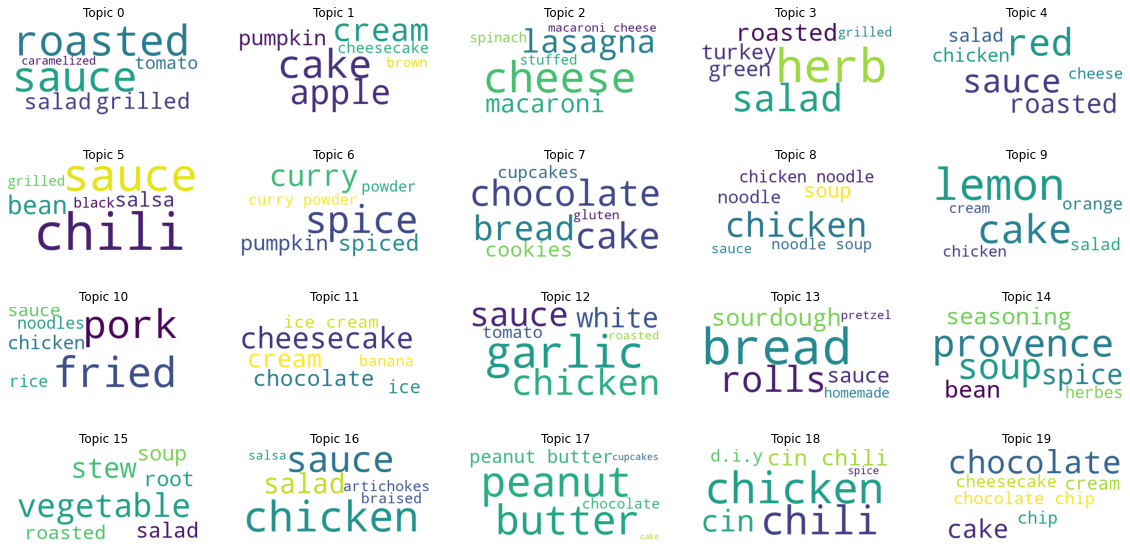

In [23]:
most_commons = summarize_topic(nmf_top_recipes[2],nmf_top_scores[2],20,50)

rows = int(len(most_commons)/5)
cols = int(len(most_commons)/rows)
figy = rows*5/2
fig = plt.figure(figsize=(20,figy))
for i, most_common in enumerate(most_commons):
    ax = fig.add_subplot(rows,cols,i+1)
    wc = make_wordcloud(most_common)
    ax.imshow(wc)
    ax.axis('off')
    ax.set_title('Topic '+str(i))
plt.savefig('word_cloud')

# LDA vs NMF Topic Coherence Graph

INFO - 13:02:43: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - 13:02:43: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - 13:02:43: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - 13:02:43: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - 13:02:43: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appr

Text(0.5, 1.0, 'NMF Topic Coherence')

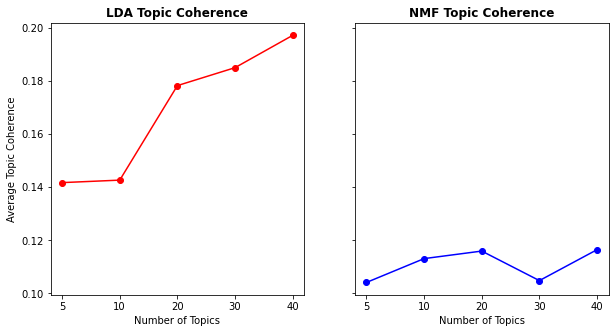

In [32]:
xlabels = [str(x) for x in ns]

lda_avg_coherence = []
for i,lda in enumerate(ldas):
    lda_avg_coherence.append(lda_topic_coherence(lda,ns[i],10))

nmf_avg_coherence = []
for i,H in enumerate(Hs):
    nmf_avg_coherence.append(nmf_topic_coherence(H,ns[i],10))

fig, axs = plt.subplots(1,2, sharey=True, figsize=(10,5))

axs[0].plot(xlabels,lda_avg_coherence, c='red',label='LDA')
axs[0].scatter(xlabels,lda_avg_coherence, c = 'red')
axs[0].set_xlabel('Number of Topics')
axs[0].set_ylabel('Average Topic Coherence')
axs[0].set_title('LDA Topic Coherence', weight='bold')

axs[1].plot(xlabels,nmf_avg_coherence, c='blue',label='NMF')
axs[1].scatter(xlabels,nmf_avg_coherence, c='blue')
axs[1].set_xlabel('Number of Topics')
axs[1].set_title('NMF Topic Coherence', weight='bold')

INFO - 13:02:52: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - 13:02:52: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - 13:02:52: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


(0.1, 0.2)

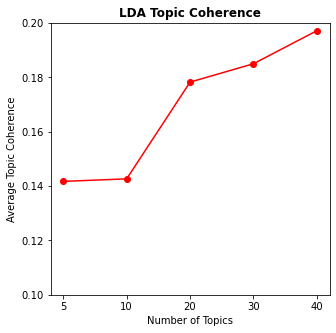

In [33]:
# Individual LDA Plot 
xlabels = [str(x) for x in ns]

fig, axs = plt.subplots(figsize=(5,5))

axs.plot(xlabels,lda_avg_coherence, c='red',label='LDA')
axs.scatter(xlabels,lda_avg_coherence, c = 'red')
axs.set_xlabel('Number of Topics')
axs.set_ylabel('Average Topic Coherence')
axs.set_title('LDA Topic Coherence', weight='bold')
axs.set_ylim([.1, .2])

INFO - 13:03:01: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - 13:03:01: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - 13:03:01: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


(0.1, 0.2)

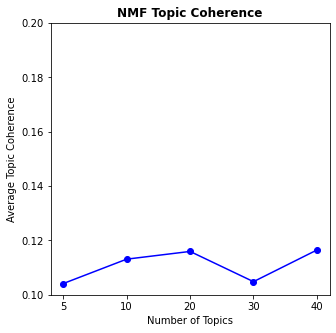

In [34]:
# Individual NMF Plot
xlabels = [str(x) for x in ns]

fig, axs = plt.subplots(figsize=(5,5))

axs.plot(xlabels,nmf_avg_coherence, c='blue',label='NMF')
axs.scatter(xlabels,nmf_avg_coherence, c = 'blue')
axs.set_xlabel('Number of Topics')
axs.set_ylabel('Average Topic Coherence')
axs.set_title('NMF Topic Coherence', weight='bold')
axs.set_ylim([.1, .2])

# Unused Extras

## Bar Charts

### Topic Distribution for various n

In [27]:
# Get summary stats for topics
recipe_stats = []
for i, lda_output in enumerate(lda_outputs):
    num_recipes_per_topic = {}
    ldadf = pd.DataFrame(lda_output)
    ranked_ldadf = ldadf.rank(pct=True, axis=1, method='first')
    for topic in range(ns[i]):
        num_recipes_per_topic[topic] = ranked_ldadf[topic].value_counts()[1]
    recipe_stats.append(num_recipes_per_topic)

In [28]:
# make bar chart
def make_num_recipe_bar(recipe_sum, n_topics, ax):
    xlabels = [str(key) for key in recipe_sum.keys()]
    # f, ax = plt.subplots()
    # ax.bar(xlabels,recipe_sum.values())
    ax.set_title('n = '+str(n_topics))
    ax.set_ylabel('Number of recipes')
    ax.set_xlabel('Topic')
    ax.bar(xlabels,recipe_sum.values())
# bar = make_num_recipe_bar(num_recipes_per_topic, n_topics)

INFO - 12:51:45: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - 12:51:45: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - 12:51:45: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - 12:51:45: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - 12:51:45: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appr

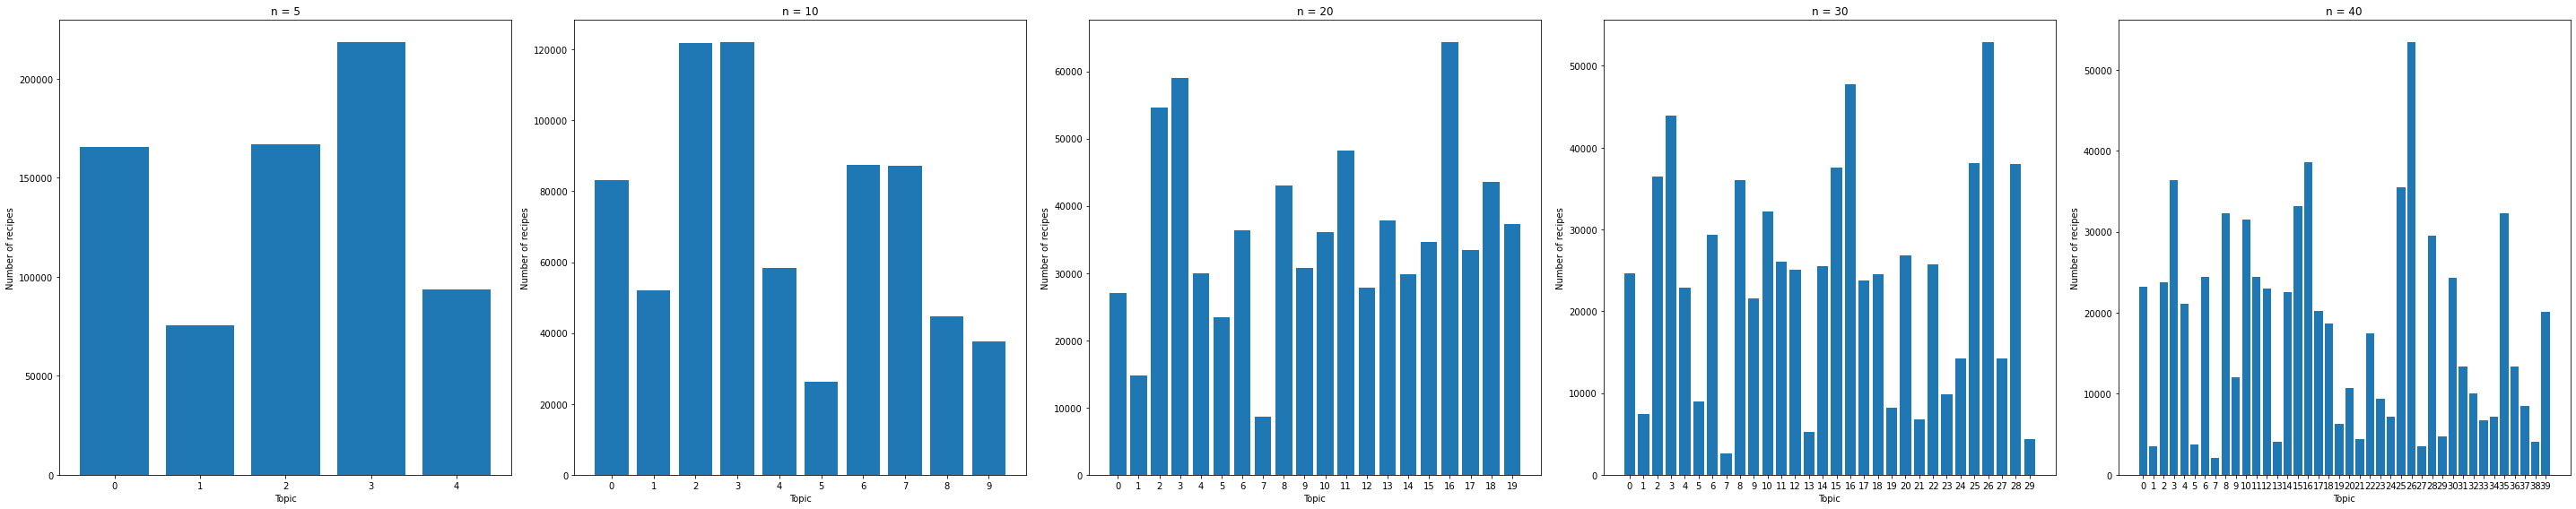

In [29]:
f, axs = plt.subplots(1,5, figsize=(40,8))
ns = [5,10,20,30,40]
for i, recipe_stat in enumerate(recipe_stats):
    make_num_recipe_bar(recipe_stat, ns[i], axs[i])
f.tight_layout()
plt.savefig('recipe_topic_nums.png')

10


INFO - 12:51:48: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - 12:51:48: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - 12:51:48: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


20


INFO - 12:51:50: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - 12:51:50: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - 12:51:50: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


30


INFO - 12:51:53: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - 12:51:53: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - 12:51:53: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


40


INFO - 12:51:58: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - 12:51:58: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - 12:51:58: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


50


INFO - 12:52:03: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - 12:52:03: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - 12:52:03: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


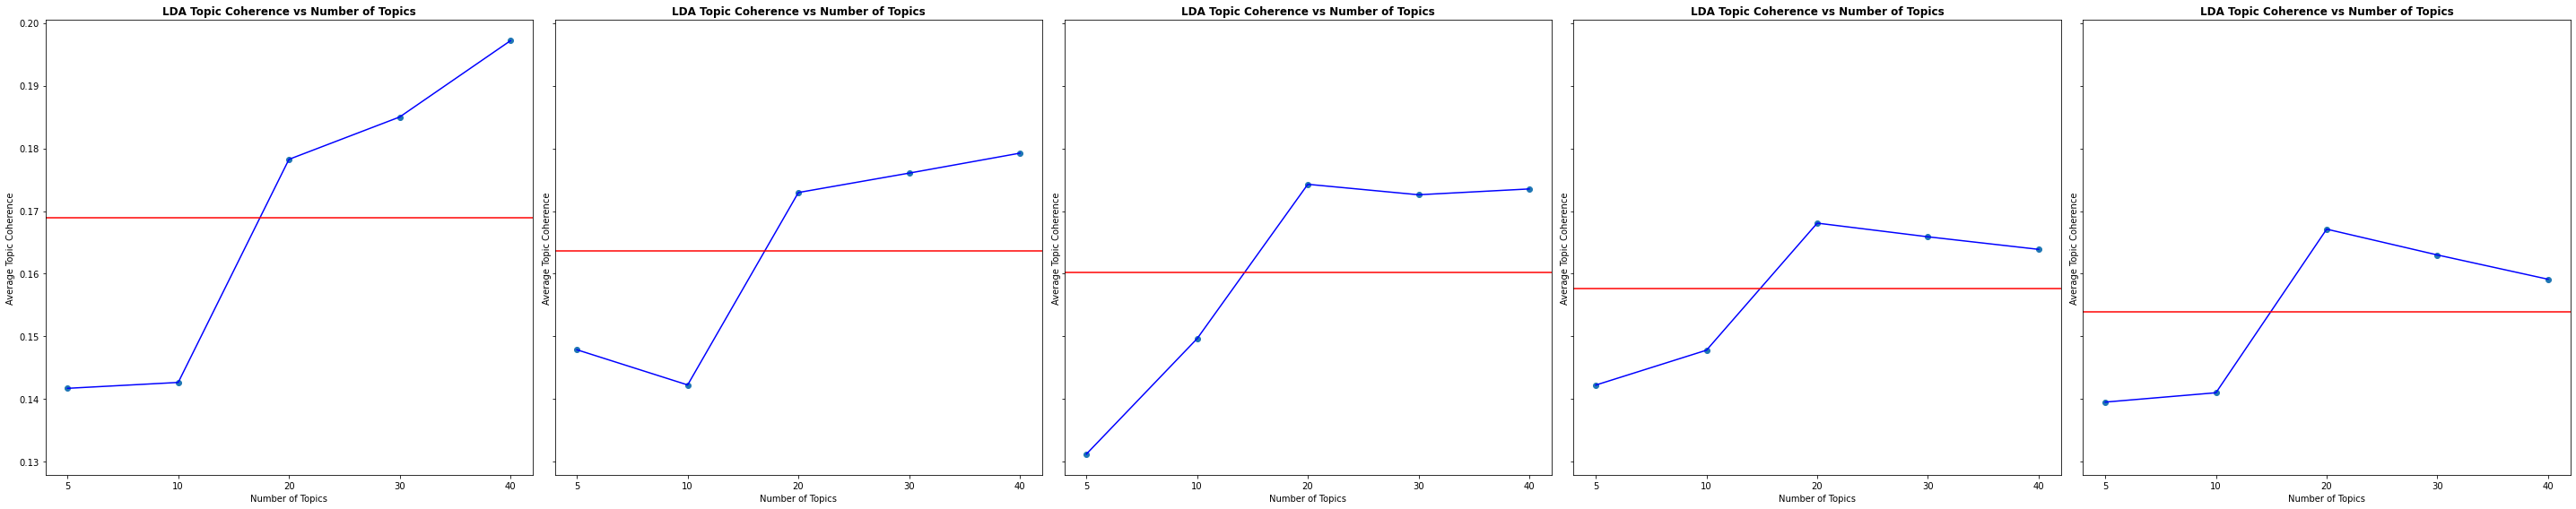

In [30]:
# LDA Topic Coherence vs Words included
f, axs = plt.subplots(1,5, figsize=(40,8), sharey=True)
n_tokens = [10,20,30,40,50]
for i,n in enumerate(n_tokens):
    print(n)
    avg_coherence = []
    for j,lda in enumerate(ldas):
        avg_coherence.append(lda_topic_coherence(lda,ns[j],n));
    plot_coherence(avg_coherence, axs[i], 'LDA')
f.tight_layout()

10


INFO - 12:52:05: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - 12:52:05: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - 12:52:05: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


20


INFO - 12:52:08: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - 12:52:08: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - 12:52:08: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


30


INFO - 12:52:11: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - 12:52:11: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - 12:52:11: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


40


INFO - 12:52:15: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - 12:52:15: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - 12:52:15: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


50


INFO - 12:52:21: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - 12:52:21: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - 12:52:21: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


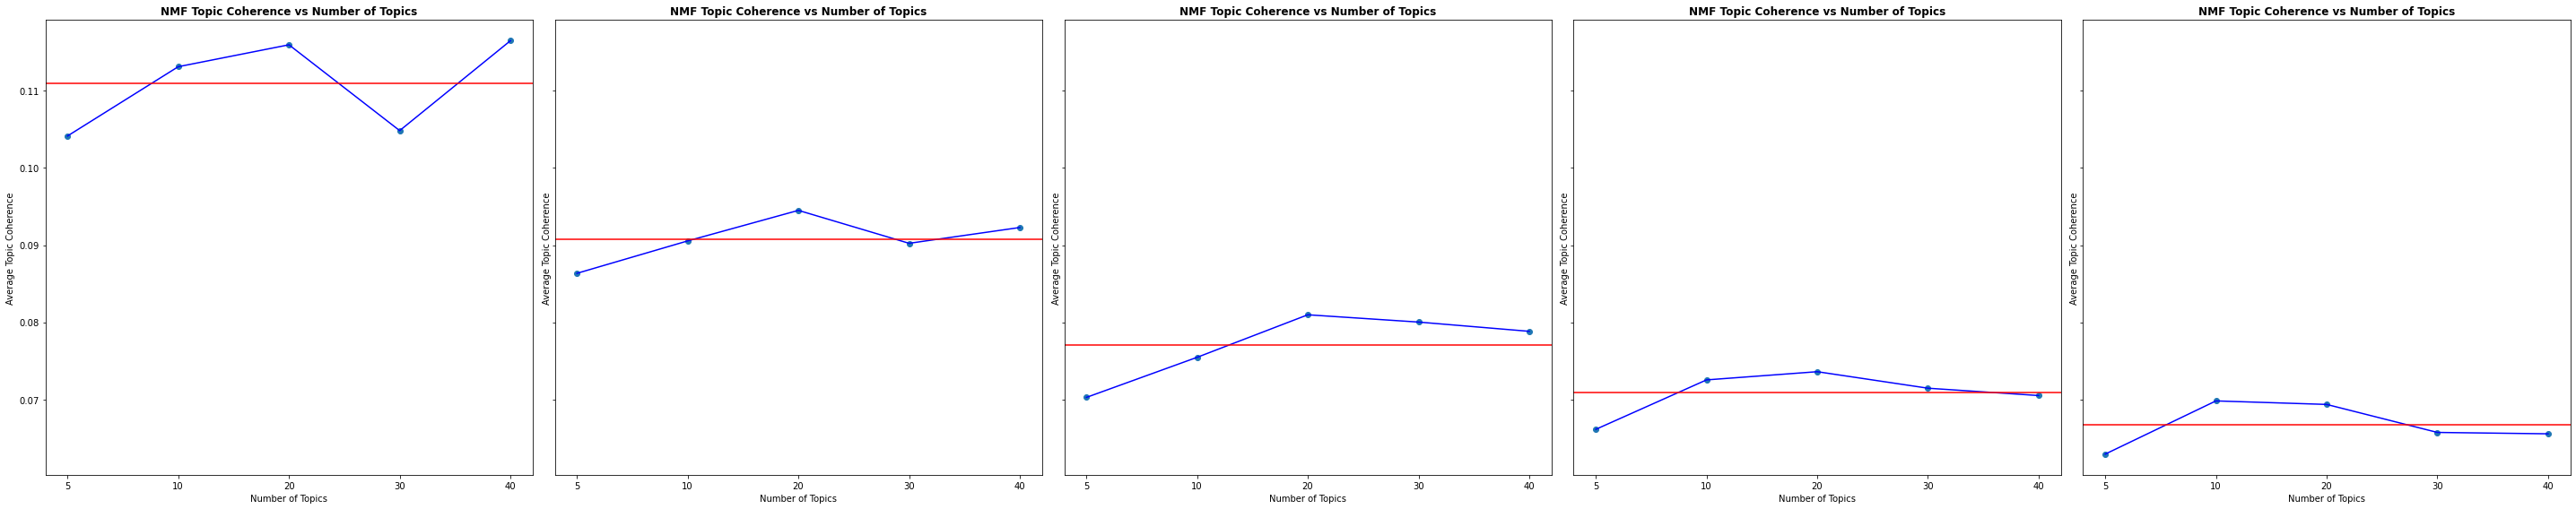

In [31]:
# NMF Topic Coherence vs Words included
f, axs = plt.subplots(1,5, figsize=(40,8), sharey=True)
n_tokens = [10,20,30,40,50]
for i,n in enumerate(n_tokens):
    print(n)
    avg_coherence = []
    for j,H in enumerate(Hs):
        avg_coherence.append(nmf_topic_coherence(H,ns[j],n))
    plot_coherence(avg_coherence, axs[i], 'NMF')
f.tight_layout()